# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp

# External imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_scatter import scatter_add

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy, get_dataset)

In [45]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [8]:
# Load by config file
config_file = '../configs/tripgnn.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

In [18]:
# Load by directory (preferred)
result_base = os.path.expandvars('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/results')

In [19]:
result_name = 'agnn01'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 1,
          'input_dir': '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_tiny',
          'n_train': 10,
          'n_valid': 1,
          'n_workers': 1,
          'name': 'hitgraphs_sparse',
          'real_weight': 5},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'tripgnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 15,
                                      'factor': 0.1,
                                      'start_epoch': 10},
                                     {'end_epoch': 20,
                                      'factor': 0.01,
                                      'start_epoch': 15}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 'output

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.915966,2719.557339,108.070848,0,7.918950,1.027840,0.320877,0.647519
1,0.001,0.837307,2723.164854,108.195346,1,14.054878,0.964037,0.325751,0.835430
2,0.001,0.806416,2725.415610,108.289032,2,13.592307,0.960778,0.372055,0.587902
3,0.001,0.797601,2726.758969,108.359692,3,8.475047,0.979984,0.365150,0.578983
4,0.001,0.791895,2727.667087,108.418767,4,10.890227,0.949364,0.394801,0.885821
5,0.001,0.786330,2728.289093,108.473218,5,8.240582,0.880158,0.403331,0.645767
6,0.001,0.787411,2728.851150,108.536833,6,10.015760,0.900376,0.409017,0.694767
7,0.001,0.786339,2729.801200,108.600357,7,11.379674,0.901857,0.437855,0.565156
8,0.001,0.777156,2730.630186,108.656332,8,10.743606,0.928969,0.397238,0.633827
9,0.001,0.769651,2731.296727,108.717880,9,10.350907,0.901468,0.451259,1.493094


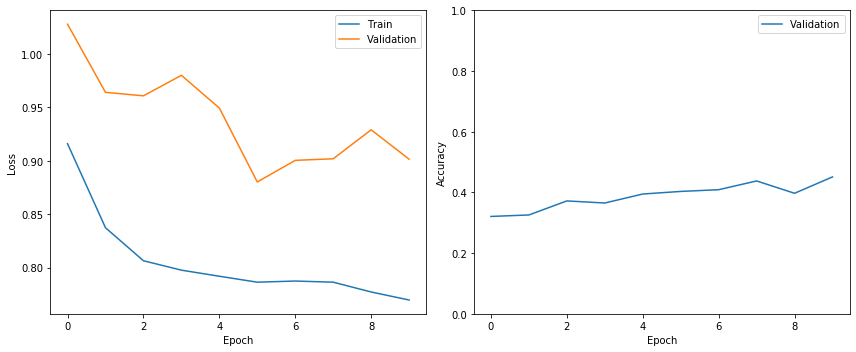

In [93]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

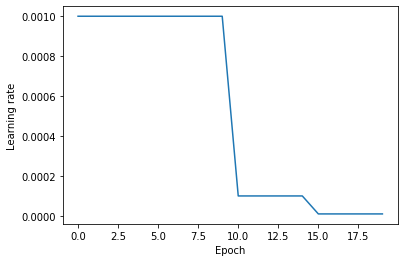

In [94]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [20]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
5,0.001,0.78633,2728.289093,108.473218,5,8.240582,0.880158,0.403331,0.645767


In [21]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [22]:
# Load the test dataset
n_test = 10
test_loader = get_test_data_loader(config, n_test=n_test)

In [23]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 2.95 s, sys: 406 ms, total: 3.36 s
Wall time: 1.91 s


In [24]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.3952
Precision: 0.2962
Recall:    0.9505


In [25]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.7806
Precision: 0.5911
Recall:    0.5269


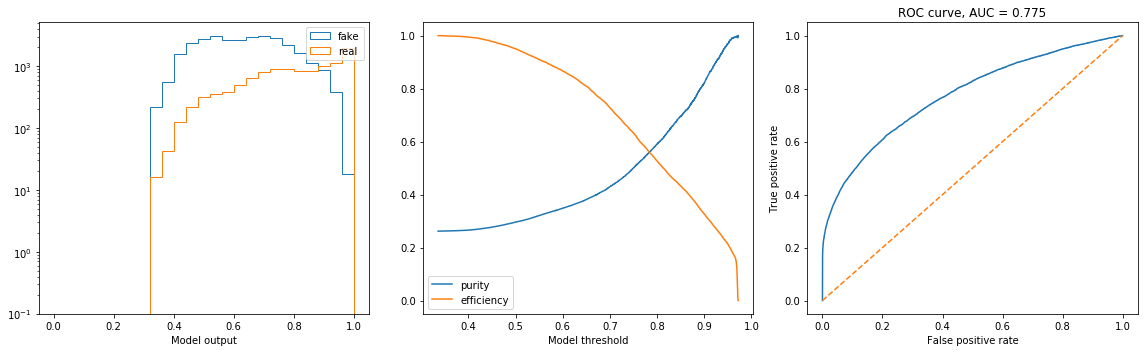

In [26]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [27]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [35]:
i = 1

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

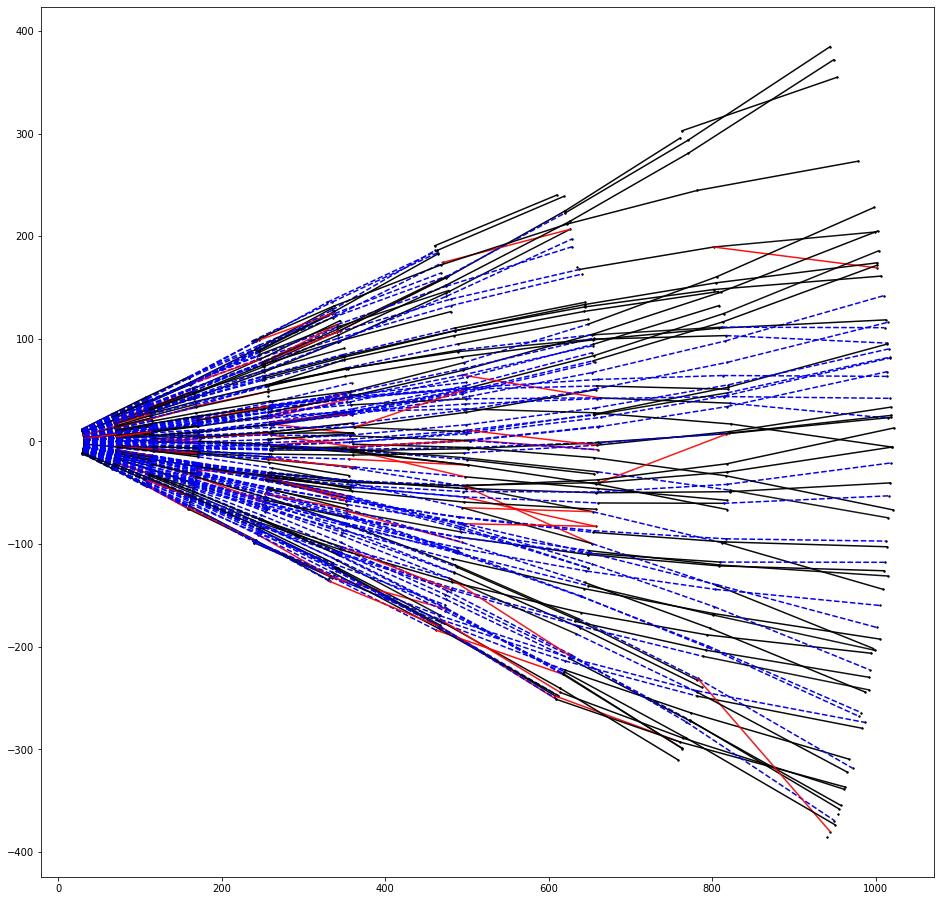

In [29]:
draw_sample_xy(x, e, o, y, cut=0.9);

## Writing data files

In [97]:
n_test = 10
test_loader = get_test_data_loader(config, n_test=n_test)
test_preds, test_targets = trainer.predict(test_loader)

In [30]:
len(test_preds)

10

In [37]:
len(test_preds[1])

4263

In [33]:
g = test_loader.dataset
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

AttributeError: 'Subset' object has no attribute 'edge_index'

In [44]:
o.shape

(4263,)

In [63]:
e = torch.tensor(e)

In [64]:
x = torch.tensor(x)

In [23]:
y

array([1., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [65]:
o

array([0.4662472 , 0.49123594, 0.51943   , ..., 0.8341328 , 0.83358026,
       0.7764561 ], dtype=float32)

In [145]:
e.shape

(2, 6473)

In [67]:
start, end = e

In [71]:
p = torch.cat([x[start], x[end]], dim=1)

In [49]:
m = nn.Sigmoid()
m(torch.randn(2))

tensor([0.3789, 0.5419])

In [61]:
start, end = new_e

In [87]:
new_x = torch.cat([x, x], dim=-1)

In [88]:
new_x.shape

torch.Size([1256, 6])

In [84]:
m = scatter_add(p[:, None] * new_x[start], end, dim=0, dim_size=x.shape[0])

In [85]:
m.shape

torch.Size([1256, 3379, 6])

In [82]:
p.shape, new_x.shape

(torch.Size([3379, 6]), torch.Size([1256, 6]))

In [33]:
A = np.array([[1,1,2,2,5,3,4],[2,5,3,4,2,6,6]])
start, end = A
A

array([[1, 1, 2, 2, 5, 3, 4],
       [2, 5, 3, 4, 2, 6, 6]])

In [40]:
A.shape[1]

7

In [34]:
np.transpose(np.array([[key2,key1] for key1, val1 in enumerate(start) for key2, val2 in enumerate(end) if val1 == val2]))

array([[0, 4, 0, 4, 1, 2, 3],
       [2, 2, 3, 3, 4, 5, 6]])

In [25]:
g

Data(edge_index=[2, 6473], w=[6473], x=[1732, 3], y=[6473])

In [26]:
g.w

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [61]:
Ri = np.zeros((np.max(A)+1, A.shape[1]))
Ro = np.zeros((np.max(A)+1, A.shape[1]))

In [62]:
Ri[A[0,:], np.arange(A.shape[1])]=1
Ro[A[1,:], np.arange(A.shape[1])]=1

In [71]:
Riwhere = [np.nonzero(t)[0] for t in Ri]
Rowhere = [np.nonzero(t)[0] for t in Ro]
Riwhere, Rowhere

([array([], dtype=int64),
  array([0, 1]),
  array([2, 3]),
  array([5]),
  array([6]),
  array([4]),
  array([], dtype=int64)],
 [array([], dtype=int64),
  array([], dtype=int64),
  array([0, 4]),
  array([2]),
  array([3]),
  array([1]),
  array([5, 6])])

In [85]:
np.array(np.meshgrid([0,1],[2,3])).T.reshape(-1,2)

array([[0, 2],
       [0, 3],
       [1, 2],
       [1, 3]])

In [91]:
E = [np.stack(np.meshgrid(j, i),-1).reshape(-1,2) for i,j in zip(Riwhere, Rowhere)]
E

[array([], shape=(0, 2), dtype=int64),
 array([], shape=(0, 2), dtype=int64),
 array([[0, 2],
        [4, 2],
        [0, 3],
        [4, 3]]),
 array([[2, 5]]),
 array([[3, 6]]),
 array([[1, 4]]),
 array([], shape=(0, 2), dtype=int64)]

In [113]:
Esmall = np.array(E)[np.array([y.size>0 for y in E])]

In [100]:
np.array([y.size>0 for y in E])

array([False, False,  True,  True,  True,  True, False])

In [126]:
Esmall[0]

array([[0, 2],
       [4, 2],
       [0, 3],
       [4, 3]])

In [127]:
Esmall[1]

array([[2, 5]])

In [131]:
np.concatenate(E).T

array([[0, 4, 0, 4, 2, 3, 1],
       [2, 2, 3, 3, 5, 6, 4]])

In [2]:
from datasets import graph

In [3]:
input = graph.load_graph('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_small_000/event000001000_g000.npz')

TypeError: sparse_to_graph() missing 1 required positional argument: 'pid'

In [8]:
input.Ri

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
input_dir = '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_tiny'
filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                         if f.startswith('event') and not f.endswith('_ID.npz') and not f.endswith('_pid.npz')]

In [5]:
%%time
inputs = graph.load_graphs(filenames)

CPU times: user 188 ms, sys: 484 ms, total: 672 ms
Wall time: 898 ms


In [6]:
print(np.array(inputs).shape)

(40, 5)


In [65]:
def load_pid(filename):
    return np.load(filename)["pid"]

In [66]:
pid_filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                         if f.startswith('event') and f.endswith('_pid.npz')]

pid_data = [load_pid(f) for f in pid_filenames]

In [70]:
len(pid_data)

40

In [108]:
G = get_dataset(config)

In [109]:
G[0]

Data(edge_index=[2, 5796], w=[5796], x=[1676, 3], y=[5796])